In [1]:
import xarray as xr
import rasterio as rio
import rioxarray
import numpy as np
import matplotlib.pyplot as plt
from osgeo import gdal
from skimage import data, filters
from scipy.interpolate import interpn

In [112]:
work_dir = '/mnt/Backups/gbrench/repos/fusits/nbs/imja/agu_push/AT12'
veloc_fn = f'{work_dir}/mintpy_offsets/velocityRg.h5'
igram_fn = f'{work_dir}/work/merged/interferograms/20200120_20200201/filt_fine.int'
cor_fn = f'{work_dir}/work/merged/interferograms/20200120_20200201/filt_fine.cor'

In [113]:
igram_ds = gdal.Open(igram_fn, gdal.GA_ReadOnly)
igram = igram_ds.GetRasterBand(1).ReadAsArray()

cor_ds = gdal.Open(cor_fn, gdal.GA_ReadOnly)
cor = cor_ds.GetRasterBand(1).ReadAsArray()

In [114]:
ds = xr.open_dataset(veloc_fn)

In [115]:
non_zero_rows = np.any(igram != 0, axis=1)
non_zero_cols = np.any(igram != 0, axis=0)

igram_crop = igram[non_zero_rows][:, non_zero_cols]

In [116]:
veloc = ds.velocity.values
non_zero_rows = np.any(veloc != 0, axis=1)
non_zero_cols = np.any(veloc != 0, axis=0)

veloc_crop = veloc[non_zero_rows][:, non_zero_cols]

In [117]:
# for some reason cor is a different shape? What the hell
non_zero_rows = np.any(cor != 0, axis=1)
non_zero_cols = np.any(cor != 0, axis=0)

cor_crop = cor[non_zero_rows][:, non_zero_cols]

In [118]:
# interpolate to match interferogram dimensions
x_coords = np.linspace(0, veloc_crop.shape[1]-1, veloc_crop.shape[1])
y_coords = np.linspace(0, veloc_crop.shape[0]-1, veloc_crop.shape[0])

# Create a mesh grid for the numpy array's dimensions
x_coords_new, y_coords_new = np.meshgrid(
    np.linspace(x_coords.min(), x_coords.max(), igram_crop.shape[1]),
    np.linspace(y_coords.min(), y_coords.max(), igram_crop.shape[0])
)

# Perform bilinear interpolation using scipy.interpolate.interpn
veloc = interpn((y_coords, x_coords), veloc_crop, (y_coords_new, x_coords_new), method="linear")

In [119]:
# filter to remove some noise
veloc_filtered = filters.butterworth(veloc,
                                     cutoff_frequency_ratio=0.35, #between 0 and 0.5
                                     order=2,
                                     high_pass=False)

In [120]:
#veloc_low_cor = np.where(cor_crop < 1.5, veloc_filtered, 0)

In [121]:
# convert to phase for simulated 3 day period
veloc_unwrapped = (veloc_filtered-0.6)*(12/365)*(12.5663706/0.05546576)

In [122]:
veloc_wrapped = np.mod(veloc_unwrapped,2*np.pi)

In [123]:
complex_conjugate_array = np.conjugate(np.exp(1j * veloc_wrapped))

In [124]:
residual = igram_crop*complex_conjugate_array

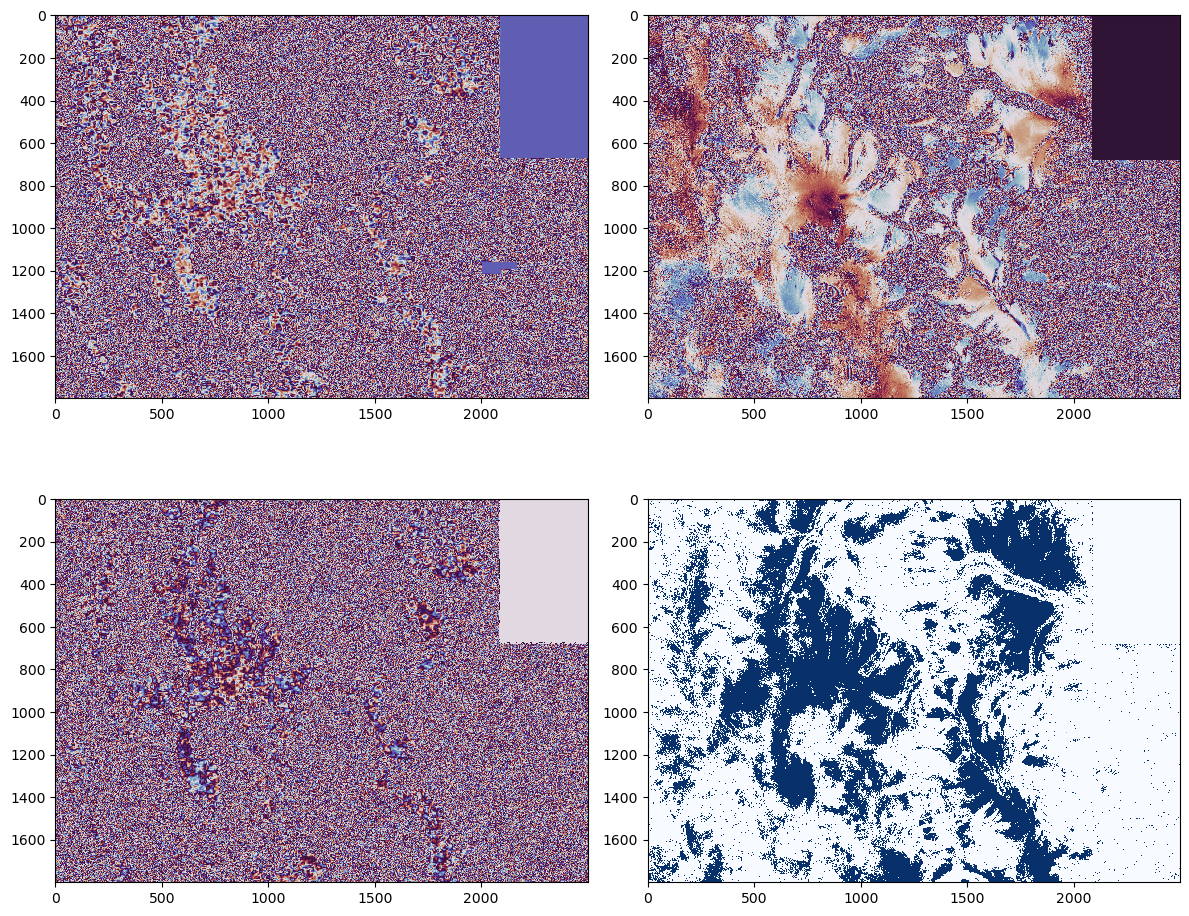

In [125]:
f, ax = plt.subplots(2, 2, figsize=(12, 10))
ax[0, 0].imshow(np.flip(veloc_wrapped, 0)[200:2000, 2000:4500], cmap='twilight', interpolation='none')
ax[0, 1].imshow(np.flip(np.angle(igram_crop), 0)[200:2000, 2000:4500], cmap='twilight', interpolation='none')
ax[1, 0].imshow(np.flip(np.angle(residual), 0)[200:2000, 2000:4500], cmap='twilight_shifted', interpolation='none')
ax[1, 1].imshow(np.flip(cor_crop, 0)[200:2000, 2000:4500], cmap='Blues', vmin=0.5, vmax=0.501, interpolation='none')
f.tight_layout()

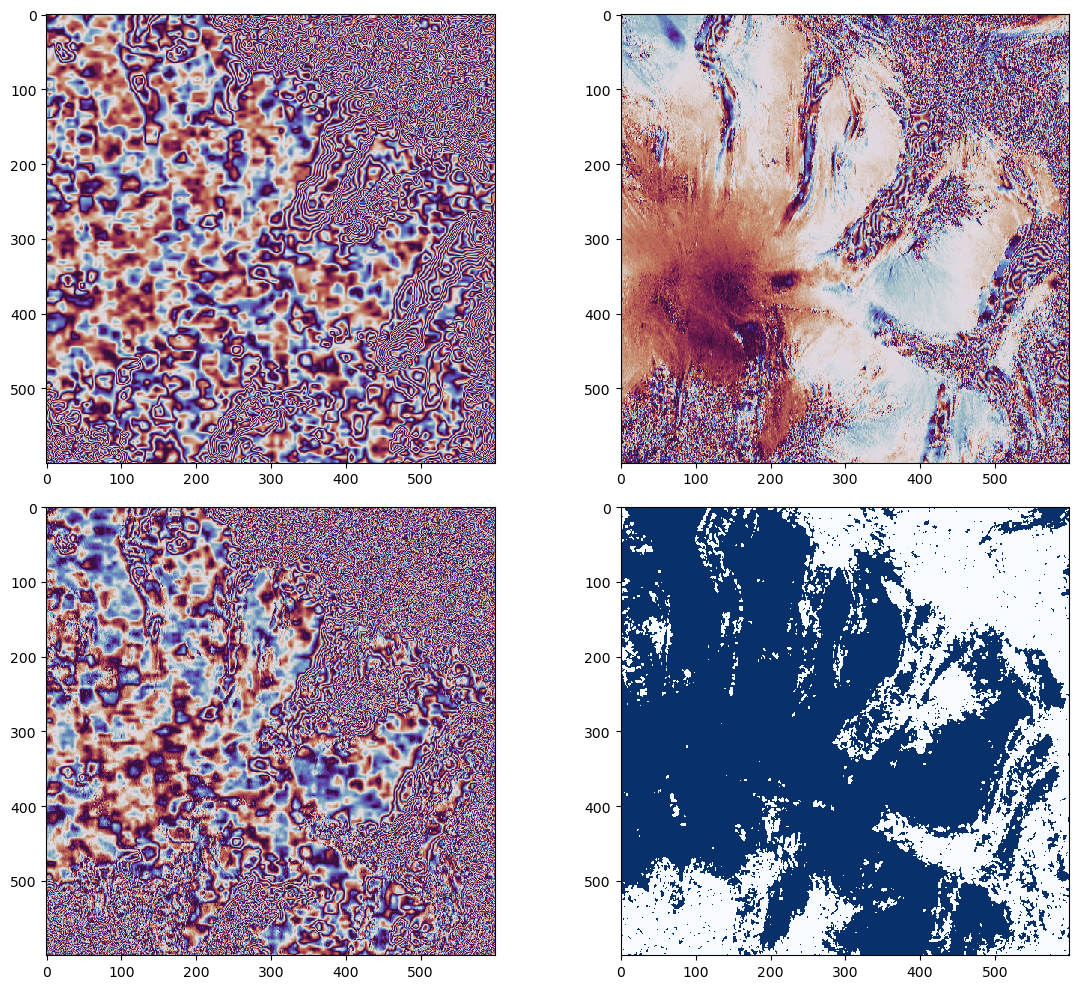

In [126]:
f, ax = plt.subplots(2, 2, figsize=(12, 10))
ax[0, 0].imshow(np.flip(veloc_wrapped, 0)[700:1300, 2700:3300], cmap='twilight', interpolation='none')
ax[0, 1].imshow(np.flip(np.angle(igram_crop), 0)[700:1300, 2700:3300], cmap='twilight', interpolation='none')
ax[1, 0].imshow(np.flip(np.angle(residual), 0)[700:1300, 2700:3300], cmap='twilight', interpolation='none')
ax[1, 1].imshow(np.flip(cor_crop, 0)[700:1300, 2700:3300], cmap='Blues', vmin=0.5, vmax=0.501, interpolation='none')
f.tight_layout()

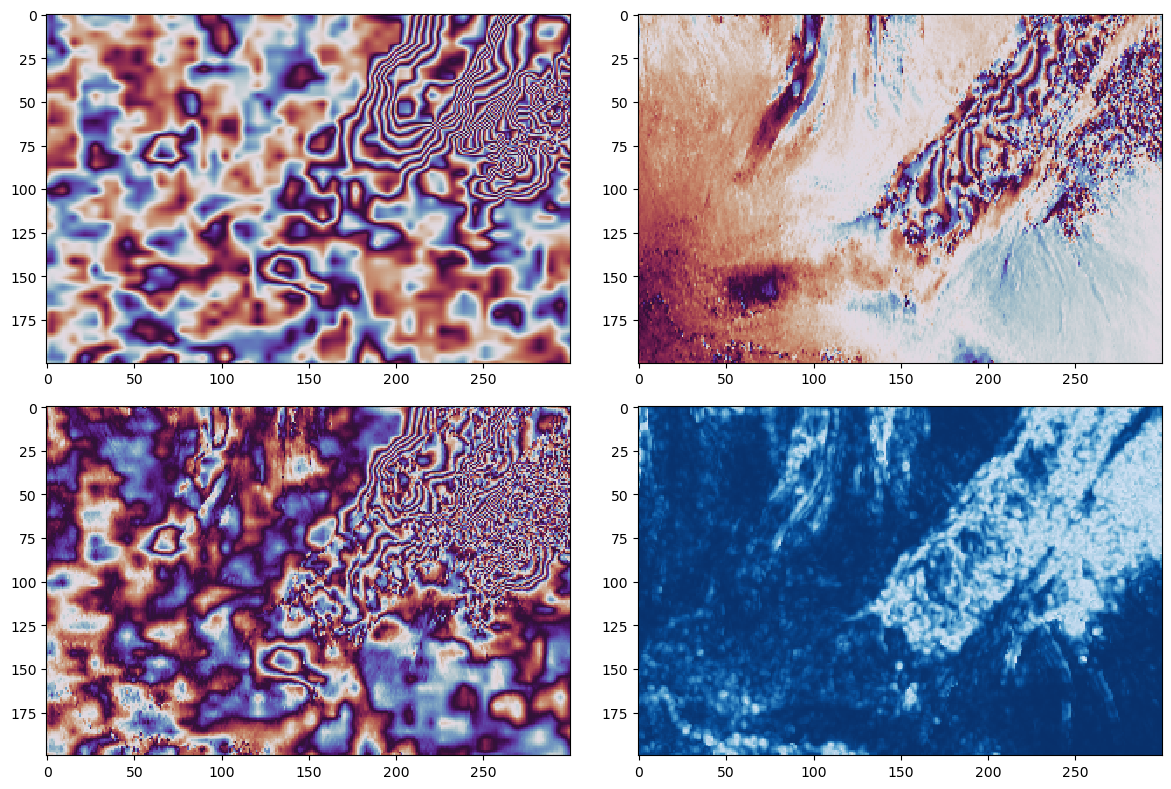

In [127]:
f, ax = plt.subplots(2, 2, figsize=(12, 8))
ax[0, 0].imshow(np.flip(veloc_wrapped, 0)[900:1100, 2850:3150], cmap='twilight', interpolation='none')
ax[0, 1].imshow(np.flip(np.angle(igram_crop), 0)[900:1100, 2850:3150], cmap='twilight', interpolation='none')
ax[1, 0].imshow(np.flip(np.angle(residual), 0)[900:1100, 2850:3150], cmap='twilight_shifted', interpolation='none')
ax[1, 1].imshow(np.flip(cor_crop, 0)[900:1100, 2850:3150], cmap='Blues', vmin=0, vmax=1, interpolation='none')
f.tight_layout()

In [128]:
# f, ax = plt.subplots(2, 2, figsize=(12, 10))
# ax[0, 0].imshow(np.flip(veloc_wrapped, 0)[0:65, 0:65], cmap='twilight', interpolation='none')
# ax[0, 1].imshow(np.flip(np.angle(igram_crop), 0)[0:65, 0:65], cmap='twilight', interpolation='none')
# ax[1, 0].imshow(np.flip(np.angle(residual), 0)[0:65, 0:65], cmap='twilight_shifted', interpolation='none')
# ax[1, 1].imshow(np.flip(ds.velocity.values, 0)[0:65, 0:65], cmap='RdBu', vmin=-1, vmax=1, interpolation='none')
# f.tight_layout()

In [129]:
# f, ax = plt.subplots(2, 2, figsize=(12, 10))
# ax[0, 0].imshow(np.flip(veloc_wrapped, 0)[-100:, -100:], cmap='twilight', interpolation='none')
# ax[0, 1].imshow(np.flip(np.angle(igram_crop), 0)[-100:, -100:], cmap='twilight', interpolation='none')
# ax[1, 0].imshow(np.flip(np.angle(residual), 0)[-100:, -100:], cmap='twilight_shifted', interpolation='none')
# ax[1, 1].imshow(np.flip(ds.velocity.values, 0)[-100:, -100:], cmap='RdBu', vmin=-1, vmax=1, interpolation='none')
# f.tight_layout()